In [1]:
# streamlit_dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
import re
import os

In [26]:
def preprocesar_datos_finca_raiz(df):
    """
    Preprocesa un DataFrame de propiedades inmobiliarias con estructura específica
    """
    # ---- 1. Limpieza inicial ----
    # Eliminar columnas no deseadas
    columnas_desechar = [
        'Estrato', 'Parqueaderos', 'Financiación', 'Formas de pago',
        'Cuota inicial', 'Pisos interiores', 'Aplica subsidio',
        'Unidades', 'Error detalle'
    ]
    df = df.drop(columns=[col for col in columnas_desechar if col in df.columns], errors='ignore')
    # Eliminar filas duplicadas
    df = df.drop_duplicates(subset=['Título', 'URL detalle'], keep='first')

    # ---- 2. Transformar precio ----
    def extraer_precio(valor):
        if pd.isna(valor):
            return np.nan
        try:
            # Extraer solo dígitos y puntos, eliminar palabras
            num_str = re.sub(r'[^\d.]', '', valor.split('$')[-1])
            # Convertir a float y manejar valores grandes
            return float(num_str.replace('.', ''))
        except:
            return np.nan
        

    df['Precio'] = df['Precio listado'].apply(extraer_precio)
    df = df.drop(columns=['Precio listado'])

    # ---- 3. Transformar tipología ----
    def extraer_tipologia(valor):
        resultado = {
            'Habitaciones': np.nan,
            'Baños': np.nan,
            'Area_m2': np.nan,
            'Tipo_propiedad': np.nan
        }
        
        if pd.isna(valor):
            return pd.Series(resultado)
        
        # Extraer números (enteros y decimales)
        numeros = [float(x) for x in re.findall(r'\d+\.\d+|\d+', valor)]
        
        # Patrones de búsqueda
        patrones = {
            'Habitaciones': r'(\d+)\s*(?:Habs?\.?|Habitaciones?)',
            'Baños': r'(\d+)\s*(?:Baños?|Banos?)',
            'Area_m2': r'(\d+\.\d+|\d+)\s*(?:m²|m2|metros)'
        }
        
        for key, pat in patrones.items():
            match = re.search(pat, valor, re.IGNORECASE)
            if match:
                # Para áreas, usar el número capturado
                if key == 'Area_m2':
                    resultado[key] = float(match.group(1))
                # Para habitaciones/baños, usar el primer número si existe
                elif numeros:
                    resultado[key] = numeros[0]
        
        return pd.Series(resultado)     
        
    # Aplicar y combinar resultados
    tipologia_df = df['Tipología listado'].apply(extraer_tipologia)
    df = pd.concat([df, tipologia_df], axis=1)
    # df = df.drop(columns=['Tipología listado'])

    # ---- 4. Normalizar ubicación ----
    def normalizar_ubicacion(ubicacion):
        if pd.isna(ubicacion):
            return pd.Series({
                'Ciudad': 'Desconocido',
                'Departamento': 'Desconocido'
            })

        partes = ubicacion.split(',')

        ciudad = partes[0].strip().title() if len(partes) > 0 else 'Desconocido'
        departamento = partes[1].strip().title() if len(partes) > 1 else 'Desconocido'

        return pd.Series({
            'Ciudad': ciudad,
            'Departamento': departamento
        })

    # Aplicar la función
    ubicacion_df = df['Ubicación listado'].apply(normalizar_ubicacion)
    df = pd.concat([df, ubicacion_df], axis=1)

    # df = df.drop(columns=['Ubicación listado'])


    # ---- 5. Extraer Barrio ----
    def extraer_barrio(descripcion):
        if pd.isna(descripcion):
            return 'Desconocido'

        # Patrón 1: después de 'venta en' y antes de la coma
        match_con_coma = re.search(r'venta en\s+([^\.,]+?),', descripcion, re.IGNORECASE)
        if match_con_coma:
            return match_con_coma.group(1).strip().title()

        # Patrón 2: después de 'venta en' hasta el final (sin coma)
        match_sin_coma = re.search(r'venta en\s+([^\.,]+)$', descripcion, re.IGNORECASE)
        if match_sin_coma:
            return match_sin_coma.group(1).strip().title()

        return 'Desconocido'

    df['Barrio'] = df['Descripción breve'].apply(extraer_barrio)

    # ---- 6. Procesar etiquetas ----
    def procesar_etiquetas(etiquetas_str):
        if pd.isna(etiquetas_str) or etiquetas_str == '[]':
            return []
        
        try:
            # Convertir string de lista a lista real
            return eval(etiquetas_str)
        except:
            # Manejar formato incorrecto
            return [x.strip() for x in etiquetas_str.strip("[]").split(',')]

    df['Etiquetas'] = df['Etiquetas'].apply(procesar_etiquetas)

    # Crear columnas dummy para etiquetas importantes
    etiquetas_comunes = ['Proyecto', 'Destacado', 'Nuevo', 'Oportunidad']
    for etiqueta in etiquetas_comunes:
        df[f'Etiqueta_{etiqueta}'] = df['Etiquetas'].apply(lambda x: 1 if etiqueta in x else 0)

    # ---- 6. Procesar tipo de propiedad ----

    tipos_validos = {
        "apartamento", "apartamentos", "apartaestudio", "apartaestudios",
        "casa", "casas", "cabaña", "finca", "oficina", "oficinas",
        "consultorio", "bodega", "edificio", "local", "locales", "lote",
        "habitación", "habitaciones"
    }

    def extraer_tipo_propiedad(titulo: str) -> str:
        """
        Extrae el tipo de propiedad más probable a partir del título.
        Prioriza palabras conocidas en lugar de posición.
        
        Args:
            titulo (str): Texto del título.
        
        Returns:
            str: Tipo de propiedad (capitalizado) o 'Desconocido'.
        """
        if pd.isna(titulo) or not str(titulo).strip():
            return 'Desconocido'
        
        titulo = titulo.lower().strip()
        palabras = re.findall(r'\b[\wáéíóúñ]+\b', titulo)
        
        for palabra in palabras:
            if palabra in tipos_validos:
                return palabra.title()

        return 'Desconocido'

    df['Tipo_propiedad'] = df['Título'].apply(extraer_tipo_propiedad)

    mapa_normalizacion = {
        'Apartamento': 'Apartamento',
        'Apartamentos': 'Apartamento',
        'Apartaestudio': 'Apartaestudio',
        'Apartaestudios': 'Apartaestudio',
        'Casa': 'Casa',
        'Casas': 'Casa',
        'Cabaña': 'Cabaña',
        'Finca': 'Finca',
        'Oficina': 'Oficina',
        'Oficinas': 'Oficina',
        'Consultorio': 'Consultorio',
        'Bodega': 'Bodega',
        'Edificio': 'Edificio',
        'Local': 'Local',
        'Locales': 'Local',
        'Lote': 'Lote',
        'Habitación': 'Habitación',
    }

    # ---- 6. Procesar tipo de propiedad ----
    def normalizar_tipo_propiedad(tipo: str) -> str:
        """
        Normaliza los valores de tipo de propiedad para unificar categorías comunes
        y filtrar valores no válidos (e.g. nombres de proyectos).
        
        Args:
            tipo (str): Tipo de propiedad detectado.
        
        Returns:
            str: Tipo de propiedad normalizado o 'Desconocido' si no se reconoce.
        """
        if pd.isna(tipo) or not str(tipo).strip():
            return 'Desconocido'
        
        tipo = tipo.strip().title()
        return mapa_normalizacion.get(tipo, 'Desconocido')

    df['Tipo_propiedad'] = df['Tipo_propiedad'].apply(normalizar_tipo_propiedad)

    columnas = ['Precio', 'Título', 'URL detalle',
        'Descripción breve', 'Descripción completa',  'Publicante',
        'Habitaciones', 'Baños', 'Area_m2', 'Tipo_propiedad',
        'Ciudad', 'Departamento', 'Barrio', 'Etiqueta_Proyecto',
        'Etiqueta_Destacado', 'Etiqueta_Nuevo', 'Etiqueta_Oportunidad']
    
    # 1. Eliminar registros con NA en 'Area_m2' o 'Precio'
    df = df.dropna(subset=['Area_m2', 'Precio'])

    # 2. Rellenar NA en 'Descripción completa' usando 'Descripción breve'
    df['Descripción completa'] = df['Descripción completa'].fillna(df['Descripción breve'])

    # 3. Rellenar NA en 'Habitaciones' y 'Baños' con 0
    df['Habitaciones'] = df['Habitaciones'].fillna(0)
    df['Baños'] = df['Baños'].fillna(0)


    return df[columnas].reset_index(drop=True)

In [30]:
def load_data():
    # Ruta de la carpeta que contiene los archivos CSV
    folder_path = 'datos'

    # Obtener la lista de archivos CSV en la carpeta
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Lista para almacenar los DataFrames
    dataframes = []

    # Leer cada archivo CSV y agregar la columna con el nombre del archivo
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, encoding='utf-8')
        df['source_file'] = file.replace('.csv', '')  # Agregar columna con el nombre del archivo
        dataframes.append(df)

    # Concatenar todos los DataFrames
    final_df = pd.concat(dataframes, ignore_index=True)

    df = preprocesar_datos_finca_raiz(final_df)
    # df = df.dropna(subset=['Precio', 'Area_m2', 'Habitaciones', 'Ubicacion'])
    return df

In [31]:
df=load_data()

In [39]:

#def train_model(data: pd.DataFrame):
"""
Entrena un modelo de Random Forest para predecir precios de propiedades.

Parámetros:
-----------
data : pd.DataFrame
    DataFrame que contiene las variables necesarias.

Returns:
--------
model : RandomForestRegressor entrenado
feature_names : lista de nombres de columnas usadas en X
mae : float, error absoluto medio sobre el conjunto de prueba
"""

# Selección de variables
features = [
    'Area_m2', 'Habitaciones', 'Baños',
    'Tipo_propiedad', 'Ciudad', 'Departamento',
    'Etiqueta_Proyecto', 'Etiqueta_Destacado', 'Etiqueta_Nuevo', 'Etiqueta_Oportunidad'
]

# Rellenar NaN (puedes ajustar esto según tu pipeline)
data = df[features + ['Precio']].copy()
# data['Baños'] = data['Baños'].fillna(0)
# data['Habitaciones'] = data['Habitaciones'].fillna(0)
# data['Area_m2'] = data['Area_m2'].fillna(data['Area_m2'].median())

# Convertir categóricas a string (por si hay enteros codificados como categorías)
cat_cols = ['Tipo_propiedad', 'Ciudad', 'Departamento',
            'Etiqueta_Proyecto', 'Etiqueta_Destacado',
            'Etiqueta_Nuevo', 'Etiqueta_Oportunidad']
data[cat_cols] = data[cat_cols].astype(str)

# Codificación one-hot
X = pd.get_dummies(data[cat_cols], drop_first=True)
y = data['Precio']

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)

#    return model, X.columns, mae



In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Real vs Predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'y_pred_test' is not defined

<Figure size 800x600 with 0 Axes>

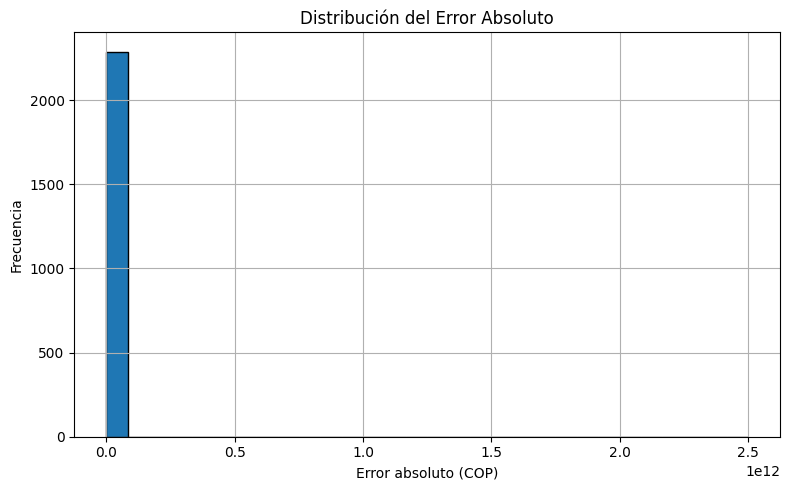

In [44]:
import numpy as np
%matplotlib inline
errores_abs = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 5))
plt.hist(errores_abs, bins=30, edgecolor='black')
plt.xlabel('Error absoluto (COP)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Error Absoluto')
plt.grid(True)
plt.tight_layout()
plt.show()


%matplotlib inline


In [ ]:


def preprocesar_datos_finca_raiz(df):
    """
    Preprocesa un DataFrame de propiedades inmobiliarias con estructura específica
    """
    # ---- 1. Limpieza inicial ----
    # Eliminar columnas no deseadas
    columnas_desechar = [
        'Estrato', 'Parqueaderos', 'Financiación', 'Formas de pago',
        'Cuota inicial', 'Pisos interiores', 'Aplica subsidio',
        'Unidades', 'Error detalle'
    ]
    df = df.drop(columns=[col for col in columnas_desechar if col in df.columns], errors='ignore')
    
    # Eliminar filas duplicadas
    df = df.drop_duplicates(subset=['Título', 'URL detalle'], keep='first')
    
    # ---- 2. Transformar precio ----
    def extraer_precio(valor):
        if pd.isna(valor):
            return np.nan
        try:
            # Extraer solo dígitos y puntos, eliminar palabras
            num_str = re.sub(r'[^\d.]', '', valor.split('$')[-1])
            # Convertir a float y manejar valores grandes
            return float(num_str.replace('.', ''))
        except:
            return np.nan
    
    df['Precio'] = df['Precio listado'].apply(extraer_precio)
    df = df.drop(columns=['Precio listado'])
    
    # ---- 3. Transformar tipología ----
    def extraer_tipologia(valor):
        resultado = {
            'Habitaciones': np.nan,
            'Baños': np.nan,
            'Area_m2': np.nan,
            'Tipo_propiedad': np.nan
        }
        
        if pd.isna(valor):
            return pd.Series(resultado)
        
        # Extraer números (enteros y decimales)
        numeros = [float(x) for x in re.findall(r'\d+\.\d+|\d+', valor)]
        
        # Patrones de búsqueda
        patrones = {
            'Habitaciones': r'(\d+)\s*(?:Habs?\.?|Habitaciones?)',
            'Baños': r'(\d+)\s*(?:Baños?|Banos?)',
            'Area_m2': r'(\d+\.\d+|\d+)\s*(?:m²|m2|metros)',
            'Tipo_propiedad': r'(Casa|Apartamento|Oficina|Local|Finca|Lote)'
        }
        
        for key, pat in patrones.items():
            match = re.search(pat, valor, re.IGNORECASE)
            if match:
                # Para áreas, usar el número capturado
                if key == 'Area_m2':
                    resultado[key] = float(match.group(1))
                # Para habitaciones/baños, usar el primer número si existe
                elif numeros:
                    resultado[key] = numeros[0]
                # Para tipo de propiedad, usar el texto
                elif key == 'Tipo_propiedad':
                    resultado[key] = match.group(1)
        
        return pd.Series(resultado)
    
    # Aplicar y combinar resultados
    tipologia_df = df['Tipología listado'].apply(extraer_tipologia)
    df = pd.concat([df, tipologia_df], axis=1)
    df = df.drop(columns=['Tipología listado'])
    
    # ---- 4. Normalizar ubicación ----
    def normalizar_ubicacion(ubicacion):
        if pd.isna(ubicacion):
            return ubicacion
        
        # Extraer ciudad y barrio
        ciudad_match = re.search(r'(Cali|Bogotá|Medellín|Barranquilla|Cartagena)', ubicacion, re.IGNORECASE)
        # barrio_match = re.search(r'(El Castillo|Valle del Lili|Granada|Poblado|El Prado)', ubicacion, re.IGNORECASE)
        
        ciudad = ciudad_match.group(1).title() if ciudad_match else 'Desconocido'
        # barrio = barrio_match.group(1) if barrio_match else 'Desconocido'
        
        return f"{ciudad}"
    
    df['Ubicacion_normalizada'] = df['Ubicación listado'].apply(normalizar_ubicacion)
    df = df.drop(columns=['Ubicación listado'])
    
    # ---- 5. Procesar etiquetas ----
    def procesar_etiquetas(etiquetas_str):
        if pd.isna(etiquetas_str) or etiquetas_str == '[]':
            return []
        
        try:
            # Convertir string de lista a lista real
            return eval(etiquetas_str)
        except:
            # Manejar formato incorrecto
            return [x.strip() for x in etiquetas_str.strip("[]").split(',')]
    
    df['Etiquetas'] = df['Etiquetas'].apply(procesar_etiquetas)
    
    # Crear columnas dummy para etiquetas importantes
    etiquetas_comunes = ['Proyecto', 'Destacado', 'Nuevo', 'Oportunidad']
    for etiqueta in etiquetas_comunes:
        df[f'Etiqueta_{etiqueta}'] = df['Etiquetas'].apply(lambda x: 1 if etiqueta in x else 0)
    
    # ---- 6. Limpieza final ----
    # Convertir a tipos adecuados
    df['Precio'] = pd.to_numeric(df['Precio'], errors='coerce')
    
    # Ordenar columnas
    column_order = [
        'Título', 'URL detalle', 'URL imagen', 'Precio', 'Habitaciones', 'Baños', 
        'Area_m2', 'Tipo_propiedad', 'Ubicacion_normalizada', 'Publicante'
    ] + [f'Etiqueta_{e}' for e in etiquetas_comunes] + ['Etiquetas', 'Descripción breve', 'Descripción completa']
    
    return df[column_order].reset_index(drop=True)



# Carga tus datos
@st.cache_data
def load_data():
    df = pd.read_csv('finca_raiz.csv', encoding='utf-8')  # Ajusta según ubicación real
    df = preprocesar_datos_finca_raiz(df)
    df = df.dropna(subset=['Precio', 'Area_m2', 'Habitaciones', 'Ubicacion_normalizada'])
    return df

# Entrena un modelo predictivo básico
@st.cache_resource
def train_model(data):
    X = pd.get_dummies(data[['Area_m2', 'Habitaciones', 'Ubicacion_normalizada']], drop_first=True)
    y = data['Precio']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return model, X.columns, mae
